In [1]:
import numpy as np
import matplotlib.pyplot as plt
# import pandas as pd

#other libraries
# from tqdm import tqdm
# import time
# import random
import os
import sys
from pathlib import Path
import h5py

#torch specific
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data

from sklearn.model_selection import train_test_split
import wandb

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn

In [2]:
module_path = str(Path.cwd().parents[0].parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *
import trainers

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "bh" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "sph" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

Running on the GPU


In [3]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [4]:
print(bhArray.shape)
print(sphArray.shape)

(15000, 50, 50, 3)
(15000, 50, 50, 3)


In [5]:
dataArray = np.concatenate((bhArray,sphArray),axis=0)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [6]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [7]:
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
trainData = torch.from_numpy(trainData)
testData = torch.from_numpy(testData)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#ResidualBlock block to be used in ResNet model
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):

        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [11]:
class ResNetModel(nn.Module):
    def __init__(self, dropout, block, layers, num_classes=2):

        super(ResNetModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.batch1 = nn.BatchNorm2d(64)

        self.inplanes = 64
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)

        # self.avgPool = nn.AvgPool2d(7, stride=1)

        self.dropout = nn.Dropout(dropout)

        self.fc0 = nn.Linear(2048, num_classes)

    def forward(self, x:Tensor):
        x = self.conv1(x)
        x = self.batch1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # x = self.avgPool(x)
        x = torch.flatten(x, 1)
        x = self.fc0(x)

        return x


    #https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)



In [12]:
from torchvision import models
from torchsummary import summary

model = ResNetModel(0,ResidualBlock, [3, 4, 6, 3]).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]           9,472
       BatchNorm2d-2           [-1, 64, 25, 25]             128
            Conv2d-3           [-1, 64, 12, 12]          36,928
       BatchNorm2d-4           [-1, 64, 12, 12]             128
              ReLU-5           [-1, 64, 12, 12]               0
            Conv2d-6           [-1, 64, 12, 12]          36,928
       BatchNorm2d-7           [-1, 64, 12, 12]             128
              ReLU-8           [-1, 64, 12, 12]               0
     ResidualBlock-9           [-1, 64, 12, 12]               0
           Conv2d-10           [-1, 64, 12, 12]          36,928
      BatchNorm2d-11           [-1, 64, 12, 12]             128
             ReLU-12           [-1, 64, 12, 12]               0
           Conv2d-13           [-1, 64, 12, 12]          36,928
      BatchNorm2d-14           [-1, 64,

In [13]:
config = {
    'epoch': 10,
    'batch_size': 50,
    'gamma': 1,
    'learning_rate': 0.01,
    'optimizer': 'adam',
    'dropout': 0
}

# Pass the config dictionary when you initialize W&B
run = wandb.init(project="ResNet34_run", config=config)

model = ResNetModel(config['dropout'], ResidualBlock, [3, 4, 6, 3]).to(device)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: 591291 (g13hvl2023). Use `wandb login --relogin` to force relogin


In [14]:
model, y_pred, y_true = trainers.run(model, train, test, config)

[Text(0, 0.5, 'Mikroskopiske svarte hull'), Text(0, 1.5, 'Sphaleroner')]

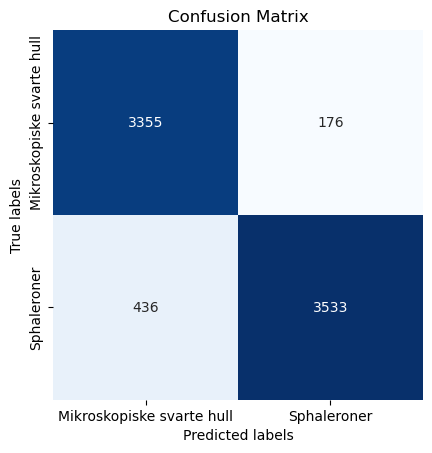

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
matrix_confusion = confusion_matrix([x.data.cpu().numpy() for x in y_pred], [x.data.cpu().numpy() for x in y_true])
ax= plt.subplot()
sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Mikroskopiske svarte hull', 'Sphaleroner'])
ax.yaxis.set_ticklabels(['Mikroskopiske svarte hull', 'Sphaleroner'])